In [204]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"  # 'tensorflow', 'jax´ or 'torch'
import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import skforecast
from skforecast.plot import set_dark_theme
from skforecast.datasets import fetch_dataset
from skforecast.deep_learning import ForecasterRnn
from skforecast.deep_learning.utils import create_and_compile_model
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_forecaster_multiseries

from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping

In [205]:
train_energy = pd.read_csv('data/train_energy.csv')
train_energy.head()

,DateTime,EnergyConsumption(kWh)
0,2015-11-01 00:00:00,15
1,2015-11-01 01:00:00,13
2,2015-11-01 02:00:00,10
3,2015-11-01 03:00:00,7
4,2015-11-01 04:00:00,9


In [206]:
# pase DateTime column to datetime
train_energy['DateTime'] = pd.to_datetime(train_energy['DateTime'])

# set DateTime column as index
train_energy = train_energy.set_index('DateTime')

# Set the frequency of the time series index
train_energy.index.freq = 'H'

train_energy.head()

/tmp/ipykernel_98541/1900792997.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  train_energy.index.freq = 'H'


,EnergyConsumption(kWh)
DateTime,
2015-11-01 00:00:00,15
2015-11-01 01:00:00,13
2015-11-01 02:00:00,10
2015-11-01 03:00:00,7
2015-11-01 04:00:00,9


In [207]:
# Checking the frequency of the time series
# ==============================================================================
print(f"Index: {train_energy.index.dtype}")
print(f"Frequency: {train_energy.index.freq}")

Index: datetime64[ns]
Frequency: <Hour>


In [208]:
# Split train-validation-test
# ==============================================================================
split_index_train = int(0.7 * len(train_energy))
split_index_val = int(0.9 * len(train_energy))

train_energy_train = train_energy[:split_index_train]
train_energy_val = train_energy[split_index_train:split_index_val]
train_energy_test = train_energy[split_index_val:]

# creting a train+validation set
train_energy_train_val = train_energy[:split_index_val]


print(
    f"Dates train      : {train_energy_train.index.min()} --- " 
    f"{train_energy_train.index.max()}  (n={len(train_energy_train)})"
)
print(
    f"Dates validation : {train_energy_val.index.min()} --- " 
    f"{train_energy_val.index.max()}  (n={len(train_energy_val)})"
)
print(
    f"Dates test       : {train_energy_test.index.min()} --- " 
    f"{train_energy_test.index.max()}  (n={len(train_energy_test)})"
)

Dates train      : 2015-11-01 00:00:00 --- 2016-08-25 21:00:00  (n=7174)
Dates validation : 2016-08-25 22:00:00 --- 2016-11-19 07:00:00  (n=2050)
Dates test       : 2016-11-19 08:00:00 --- 2017-01-01 00:00:00  (n=1025)


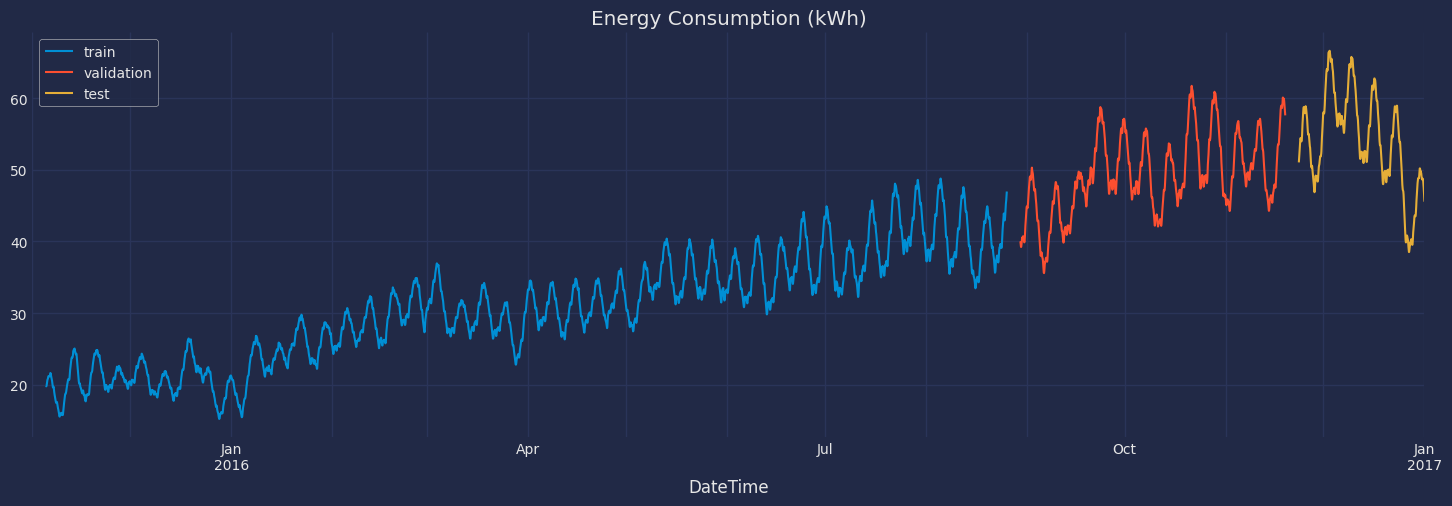

In [209]:
# Plotting one feature
# ==============================================================================
set_dark_theme()
fig, ax = plt.subplots(figsize=(16, 5))
train_energy_train["EnergyConsumption(kWh)"].rolling(100).mean().plot(ax=ax, label="train")
train_energy_val["EnergyConsumption(kWh)"].rolling(100).mean().plot(ax=ax, label="validation")
train_energy_test["EnergyConsumption(kWh)"].rolling(100).mean().plot(ax=ax, label="test")
ax.set_title("Energy Consumption (kWh)")
ax.legend();

In [210]:
# Model creation
# ==============================================================================
series = ["EnergyConsumption(kWh)"]  # Series used as predictors
levels = ["EnergyConsumption(kWh)"]  # Target series to predict
lags = 32  # Past time steps to be used to predict the target
steps = 5  # Future time steps to be predicted

model = create_and_compile_model(
    series=train_energy_train,
    levels=levels, 
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=150,
    dense_units=32,
    optimizer=Adam(learning_rate=0.01), 
    loss=MeanSquaredError()
)
model.summary()

keras version: 3.7.0
Using backend: tensorflow
tensorflow version: 2.18.0


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 32, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 150)            │        91,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │         4,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 5)              │           165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_13 (Reshape)            │ (None, 5, 1)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,197 (375.77 KB)

 Trainable params: 96,197 (375.77 KB)

 Non-trainable params: 0 (0.00 B)

In [211]:
# Forecaster Creation
# ==============================================================================
forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    transformer_series=MinMaxScaler(),
    fit_kwargs={
        "epochs": 50,  # Number of epochs to train the model.
        "batch_size": 64,  # Batch size to train the model.
        "callbacks": [
            EarlyStopping(monitor="val_loss", patience=10)
        ],  # Callback to stop training when it is no longer learning.
        "series_val": train_energy_val,  # Validation data for model training.
    },
)    

forecaster

/home/adel_hb/.local/lib/python3.10/site-packages/skforecast/deep_learning/_forecaster_rnn.py:229: UserWarning: Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.
  warnings.warn(
/home/adel_hb/.local/lib/python3.10/site-packages/skforecast/deep_learning/_forecaster_rnn.py:264: UserWarning: `steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.
  warnings.warn(


ForecasterRnn 
Regressor: <Functional name=functional_13, built=True> 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32] 
Transformer for series: MinMaxScaler() 
Window size: 32 
Target series, levels: ['EnergyConsumption(kWh)'] 
Multivariate series (names): None 
Maximum steps predicted: [1 2 3 4 5] 
Training range: None 
Training index type: None 
Training index frequency: None 
Model parameters: {'name': 'functional_13', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 32, 1), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_13'}, 'registered_name': None, 'name': 'input_layer_13', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'lstm_13', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'return_sequences': False, 'return_state'

In [212]:
# Fit forecaster
# ==============================================================================
forecaster.fit(train_energy_train)

Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 8.1606 - val_loss: 0.0328
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0256 - val_loss: 0.0321
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0201 - val_loss: 0.0214
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0120 - val_loss: 0.0091
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0058 - val_loss: 0.0078
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0049 - val_loss: 0.0067
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0048 - val_loss: 0.0071
Epoch 8/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0044 - val_loss: 0.0066
Epoch 9/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0039 - val_loss: 0.0060
Epoch 10/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0042 - val_loss: 0.0054
Epoch 11/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0039 - val_loss: 0.0050
Epoch 12/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 

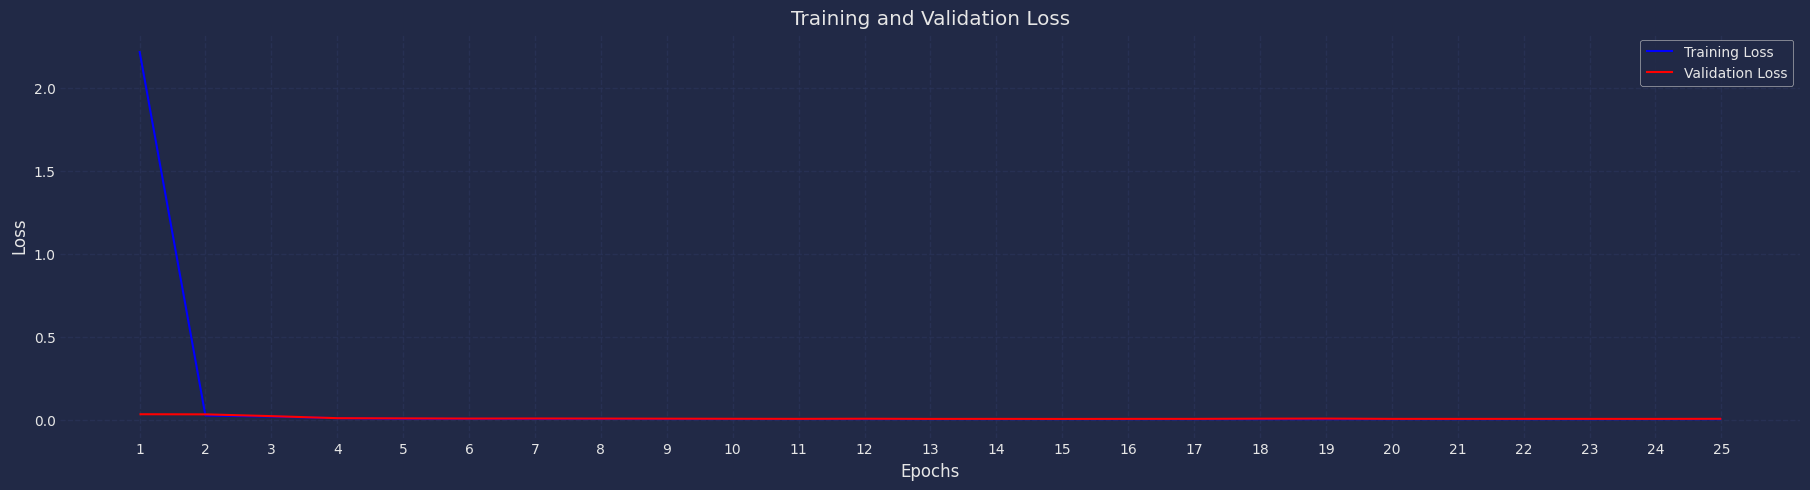

In [ ]:
# Train and overfitting tracking
# ==============================================================================
fig, ax = plt.subplots(figsize=(20, 10))
forecaster.plot_history(ax=ax)

In [214]:
# Prediction
# ==============================================================================
predictions = forecaster.predict()
predictions

/home/adel_hb/.local/lib/python3.10/site-packages/skforecast/deep_learning/_forecaster_rnn.py:727: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.5483871   0.49462366  0.48387097  0.51612903  0.55913978  0.60215054
  0.50537634  0.47311828  0.49462366  0.44086022  0.13978495  0.03225806
 -0.08602151  0.15053763  0.13978495  0.06451613  0.10752688  0.19354839
  0.23655914  0.31182796  0.3655914   0.4516129   0.53763441  0.43010753
  0.49462366  0.41935484  0.4516129   0.4516129   0.4516129   0.5483871
  0.53763441  0.49462366]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  last_window.loc[:, serie_name] = last_window_values


,EnergyConsumption(kWh)
2016-08-25 22:00:00,51.185440
2016-08-25 23:00:00,48.040199
2016-08-26 00:00:00,42.773300
2016-08-26 01:00:00,36.748405
2016-08-26 02:00:00,33.997597


In [215]:
# Specific step predictions
# ==============================================================================
predictions = forecaster.predict(steps=[1, 3])
predictions

/home/adel_hb/.local/lib/python3.10/site-packages/skforecast/deep_learning/_forecaster_rnn.py:727: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.5483871   0.49462366  0.48387097  0.51612903  0.55913978  0.60215054
  0.50537634  0.47311828  0.49462366  0.44086022  0.13978495  0.03225806
 -0.08602151  0.15053763  0.13978495  0.06451613  0.10752688  0.19354839
  0.23655914  0.31182796  0.3655914   0.4516129   0.53763441  0.43010753
  0.49462366  0.41935484  0.4516129   0.4516129   0.4516129   0.5483871
  0.53763441  0.49462366]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  last_window.loc[:, serie_name] = last_window_values


,EnergyConsumption(kWh)
2016-08-25 22:00:00,51.18544
2016-08-26 00:00:00,42.77330


In [217]:
# Backtesting 
# ==============================================================================
cv = TimeSeriesFold(
         steps              = forecaster.max_step,
         initial_train_size = split_index_val,  # Training + Validation Data
         refit              = False
     )

metrics, predictions = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    series=train_energy,
    cv=cv,
    levels=forecaster.levels,
    metric="mean_absolute_error",
    verbose=False
)

Epoch 1/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0026 - val_loss: 0.0043
Epoch 2/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0025 - val_loss: 0.0044
Epoch 3/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0023 - val_loss: 0.0044
Epoch 4/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0025 - val_loss: 0.0047
Epoch 5/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0023 - val_loss: 0.0041
Epoch 6/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0024 - val_loss: 0.0043
Epoch 7/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0023 - val_loss: 0.0042
Epoch 8/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0024 - val_loss: 0.0043
Epoch 9/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0024 - val_loss: 0.0041
Epoch 10/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0023 - val_loss: 0.0044
Epoch 11/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0024 - val_loss: 0.0041
Epoch 12/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/205 [00:00<?, ?it/s]

/home/adel_hb/.local/lib/python3.10/site-packages/skforecast/deep_learning/_forecaster_rnn.py:727: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.51612903 0.44086022 0.35483871 0.29032258 0.25806452 0.22580645
 0.24731183 0.22580645 0.30107527 0.35483871 0.44086022 0.49462366
 0.87096774 0.62365591 0.60215054 0.65591398 0.52688172 0.51612903
 0.56989247 0.62365591 0.58064516 0.59139785 0.55913978 0.48387097
 0.46236559 0.35483871 0.32258065 0.30107527 0.20430108 0.19354839
 0.15053763 0.17204301]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  last_window.loc[:, serie_name] = last_window_values
/home/adel_hb/.local/lib/python3.10/site-packages/skforecast/deep_learning/_forecaster_rnn.py:727: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.22580645 0.24731183 0.22580645 0.30107527 0.35483871 0.4408602

In [218]:
# Backtesting predictions
# ==============================================================================
predictions

,EnergyConsumption(kWh)
2016-11-19 08:00:00,29.913568
2016-11-19 09:00:00,33.534706
2016-11-19 10:00:00,39.841022
2016-11-19 11:00:00,45.971062
2016-11-19 12:00:00,49.352291
...,...
2016-12-31 20:00:00,34.748539
2016-12-31 21:00:00,35.568733
2016-12-31 22:00:00,35.936031
2016-12-31 23:00:00,35.401688


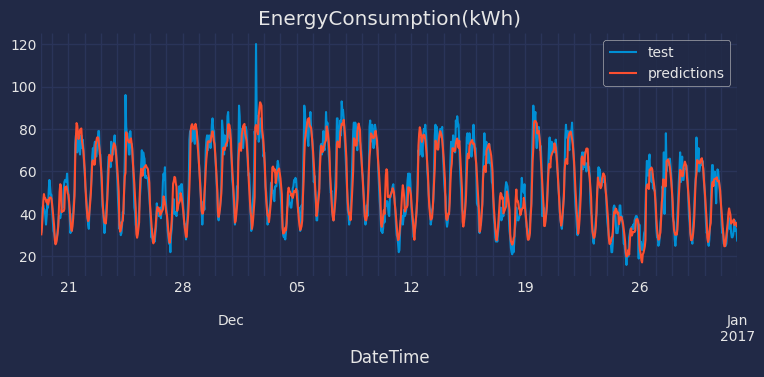

In [219]:
# Plotting predictions vs real values in the test set
# ==============================================================================
# Ensure predictions have the same index as the test set
predictions.index = train_energy_test.index

fig, ax = plt.subplots(figsize=(8, 3))
train_energy_test["EnergyConsumption(kWh)"].plot(ax=ax, label="test")
predictions["EnergyConsumption(kWh)"].plot(ax=ax, label="predictions")
ax.set_title("EnergyConsumption(kWh)")
ax.legend();

In [220]:
# Calculate metrics (MAE, MSE, RMSE, MAPE)
# ==============================================================================
from sklearn.metrics import mean_squared_error

# Calculate mean squared error
mse = mean_squared_error(train_energy_test["EnergyConsumption(kWh)"], predictions["EnergyConsumption(kWh)"])
metrics["mean_squared_error"] = mse

# Calculate root mean squared error
rmse = np.sqrt(metrics["mean_squared_error"])

metrics, rmse

(                   levels  mean_absolute_error  mean_squared_error
 0  EnergyConsumption(kWh)             4.653599           39.703225,
 0    6.301049
 Name: mean_squared_error, dtype: float64)